### TRPCA notebook for using qiime2, gemelli, and TRPCA to regress and classify microbiome samples. 

In [1]:
# imports
import pandas as pd
from sklearn.decomposition import PCA, SparsePCA, IncrementalPCA
from sklearn.model_selection import train_test_split
import numpy as np
# import qiime2 as q2
# from qiime2.plugins.feature_table.methods import rarefy
# from qiime2.plugins.gemelli.actions import rpca
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim
import torch
import torch.nn as nn
from biom import load_table
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# table = q2.Artifact.load('data/skin_1975.qza')
# rare_table = rarefy(table=table, sampling_depth=1000)
table = load_table('data/redbiom_metag_table.biom').to_dataframe(dense=True).T.astype(int)
# metadata = pd.read_csv('data/gut_4434_map.txt', sep='\t', index_col=0)  

In [3]:
# Load data
age_metadata = pd.read_csv('data/redbiom_metag_metadata.tsv', sep='\t', index_col=0)

# Drop rows where host_age_units is 'not collected', 'not provided', or nan
age_metadata = age_metadata[~age_metadata['host_age_units'].isin(['not collected', 'not provided', np.nan])]

# Convert host_age to numeric, coerce errors to NaN (non-numeric values will become NaN)
age_metadata['host_age'] = pd.to_numeric(age_metadata['host_age'], errors='coerce')

# Remove rows with non-numeric host_age or outside the range 0 to 110
age_metadata = age_metadata[(age_metadata['host_age'] >= 18) & (age_metadata['host_age'] <= 110)]

# Convert ages based on host_age_units
def convert_age(row):
    if row['host_age_units'] in ['years', 'Years']:
        return row['host_age']
    # elif row['host_age_units'] == 'months':
    #     return row['host_age'] / 12
    # elif row['host_age_units'] == 'days':
    #     return row['host_age'] / 365
    else:
        return np.nan

# Apply conversion
age_metadata['host_age_in_years'] = age_metadata.apply(convert_age, axis=1)

In [4]:
# n_dimensions = 8
# rpca_results = rpca(rare_table.rarefied_table, n_components=n_dimensions, min_feature_frequency=5)
# df = rpca_results.biplot.view(q2.Metadata).to_dataframe()

In [5]:
from TRPCA import utils
# df1 = utils.clr_transformation(table.view(pd.DataFrame)) ### for using clr_transformation on the rare table
columns_to_drop = table.columns[table.sum() < 5] #drop columns with low prev
df1 = table.drop(columns=columns_to_drop)
df1 = utils.clr_transformation(df1)
print('CLR Transformed.')

CLR Transformed.


In [6]:
n_dimensions = 512
# # # # # # Preprocess with PCA (Re-using the PCA application code from earlier)
X1_reduced, pca1 = utils.apply_pca(df1, n_dimensions) 
df = pd.DataFrame(X1_reduced, index=df1.index)

In [7]:
# df['qiita_host_age'] = metadata.loc[metadata.index.isin(df.index)].qiita_host_age
df['age'] = age_metadata.loc[age_metadata.index.isin(df.index)].host_age_in_years

In [8]:
df = df.loc[df.age.notna()]

In [9]:
df.shape

(15730, 513)

### create dataloader and definition so we do all the things behind the scenes rather than up front here

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from TRPCA import trpca

y = df.age.astype(float)

X_pca_tensor = torch.tensor(df.drop(columns=['age']).to_numpy(), dtype=torch.float32)

num_bins = 6

# Binning the targets
age_bins = pd.qcut(y, q=num_bins, labels=False, duplicates='drop')

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca_tensor, y, test_size=0.2, random_state=42, stratify=age_bins)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting to PyTorch tensors
train_features = torch.tensor(X_train_scaled, dtype=torch.float32)
test_features = torch.tensor(X_test_scaled, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
test_targets = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Creating DataLoader instances
train_dataset = TensorDataset(train_features, train_targets)
test_dataset = TensorDataset(test_features, test_targets)

batch_size = 512 # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

regression_model = trpca.TransformerRegressionModel(feature_size=n_dimensions, num_transformer_layers=3, nhead=8, dim_feedforward=2048, dropout=0.3, fast_transformer=True)

/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_5289/2743724493.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_targets = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_5289/2743724493.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_targets = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
/Users/tylermyers/anaconda3/envs/trpca_2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_fi

In [24]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in regression_model.parameters())
trainable_params = sum(p.numel() for p in regression_model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 14186497
Trainable Parameters: 14186497


In [29]:
from tqdm import tqdm 
# Loss function and optimizer
criterion = nn.HuberLoss()
optimizer = torch.optim.SGD(regression_model.parameters(), lr=8e-3, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0, last_epoch=-1)

epochs = 1000
best_valid_loss = float('inf')  # Initialize the best validation loss
train_losses = []
valid_losses = []

In [30]:
pbar = tqdm(total=epochs, desc="Training Progress")
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
for epoch in tqdm(range(epochs), total=epochs):
    regression_model.to(device)
    regression_model.train()
    train_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = regression_model(batch_features)
        loss = criterion(outputs['regression_output'], batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)
    
    # Average train loss for the epoch
    train_loss_epoch = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    
    # Validation phase
    regression_model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = regression_model(batch_features)
            loss = criterion(outputs['regression_output'], batch_labels)
            valid_loss += loss.item() * batch_features.size(0)
    
    # Average valid loss for the epoch
    valid_loss_epoch = valid_loss / len(test_loader.dataset)
    valid_losses.append(valid_loss_epoch)

    scheduler.step()
    # Update the progress bar
    pbar.update(1)
    pbar.set_postfix({
        'Epoch': epoch + 1,
        'Train Loss': f'{train_loss_epoch:.4f}',
        'Validation Loss': f'{valid_loss_epoch:.4f}'
    })
    
    # Check for best validation loss
    if valid_loss_epoch < best_valid_loss:
        best_valid_loss = valid_loss_epoch
        # Save the model
        torch.save(regression_model.state_dict(), 'best_designated_age_regression_model.pth')
        # print(f'Epoch {epoch+1}: Validation loss improved, model saved.')

# Close the progress bar after all epochs are done
pbar.close()

Training Progress: 100%|██████████| 1000/1000 [08:47<00:00,  1.89it/s, Epoch=1000, Train Loss=7.6189, Validation Loss=9.2365]


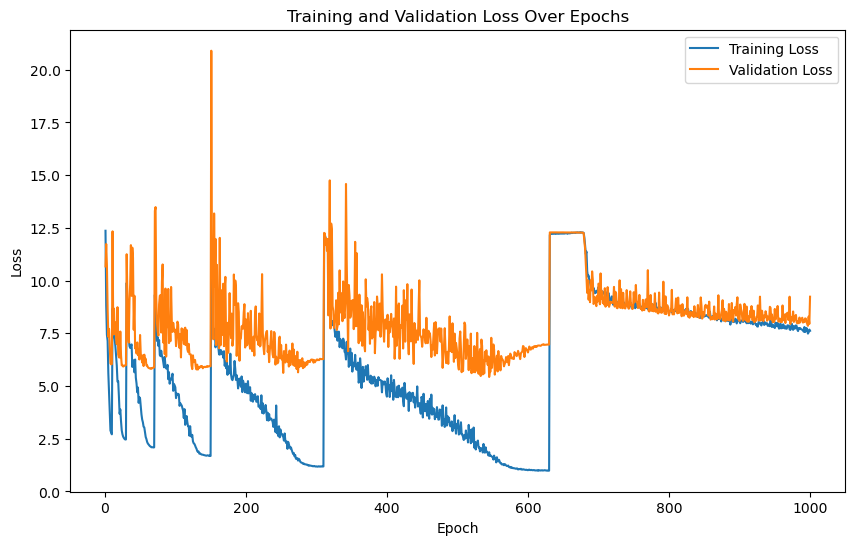

In [31]:
regression_model.load_state_dict(torch.load('best_designated_age_regression_model.pth'))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

### same here--> put this in python definition so we can hide this away

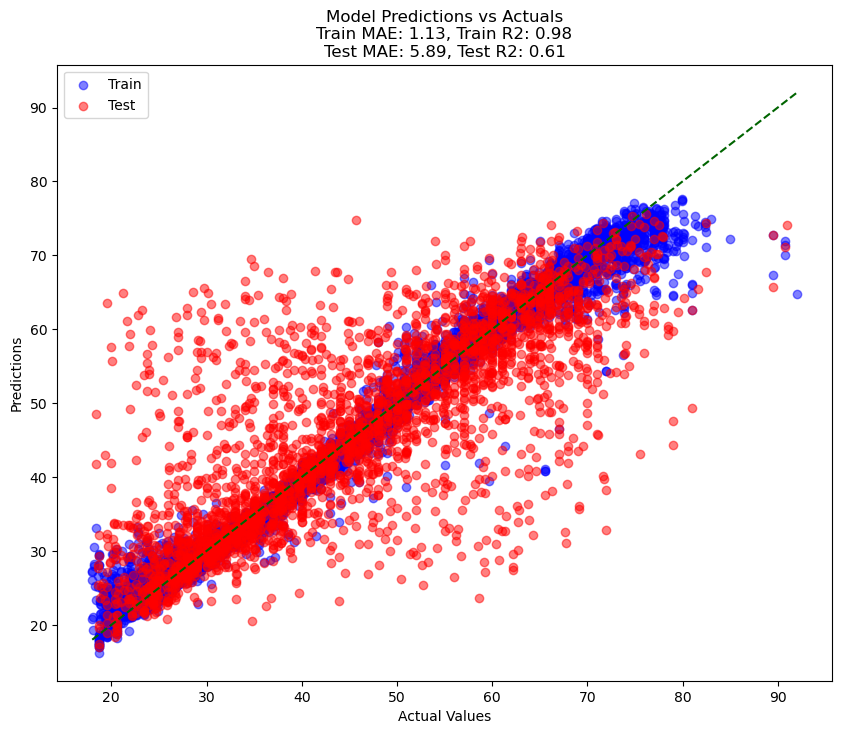

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# After training, evaluate the model on both the training and testing sets
regression_model.eval()  # Set the model to evaluation mode

# Collect predictions and actual values for the training set
train_preds, train_actuals = [], []
for batch_features, batch_labels in train_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    batch_preds = regression_model(batch_features)['regression_output'].detach()
    train_preds.extend(batch_preds.view(-1).tolist())
    train_actuals.extend(batch_labels.view(-1).tolist())

# Collect predictions and actual values for the test set
test_preds, test_actuals = [], []
for batch_features, batch_labels in test_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    batch_preds = regression_model(batch_features)['regression_output'].detach()
    test_preds.extend(batch_preds.view(-1).tolist())
    test_actuals.extend(batch_labels.view(-1).tolist())

# Calculate MAE and R^2 for training and testing sets
train_mae = mean_absolute_error(train_actuals, train_preds)
test_mae = mean_absolute_error(test_actuals, test_preds)
train_r2 = r2_score(train_actuals, train_preds)
test_r2 = r2_score(test_actuals, test_preds)

# Plotting
plt.figure(figsize=(10, 8))

# Train predictions vs actuals
plt.scatter(train_actuals, train_preds, color='blue', alpha=0.5, label='Train')
# Test predictions vs actuals
plt.scatter(test_actuals, test_preds, color='red', alpha=0.5, label='Test')

# Perfect predictions line
plt.plot([min(train_actuals+test_actuals), max(train_actuals+test_actuals)], 
         [min(train_actuals+test_actuals), max(train_actuals+test_actuals)], 
         color='darkgreen', linestyle='--')

plt.title(f'Model Predictions vs Actuals\nTrain MAE: {train_mae:.2f}, Train R2: {train_r2:.2f}\nTest MAE: {test_mae:.2f}, Test R2: {test_r2:.2f}')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

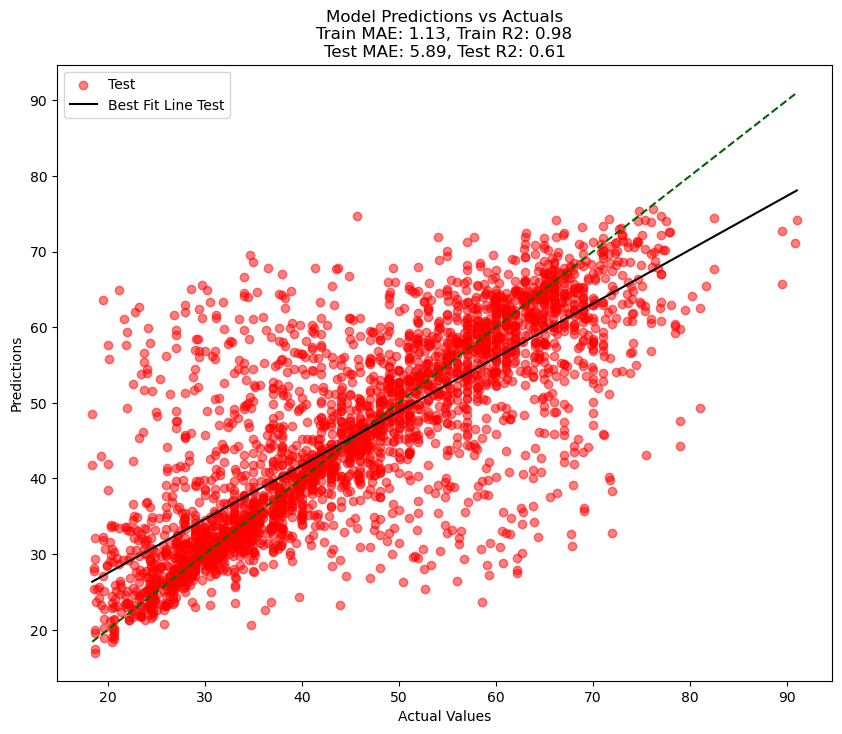

In [33]:
# Plotting
plt.figure(figsize=(10, 8))

# Train predictions vs actuals
# plt.scatter(train_actuals, train_preds, color='blue', alpha=0.5, label='Train')
# Test predictions vs actuals
plt.scatter(test_actuals, test_preds, color='red', alpha=0.5, label='Test')

# Perfect predictions line
plt.plot([min(test_actuals), max(test_actuals)],
         [min(test_actuals), max(test_actuals)],
         color='darkgreen', linestyle='--')

# Best fit line for the test data
coeffs = np.polyfit(test_actuals, test_preds, 1)
best_fit_line = np.poly1d(coeffs)(np.unique(test_actuals))
plt.plot(np.unique(test_actuals), best_fit_line, color='black', label='Best Fit Line Test', linestyle='-')

plt.title(f'Model Predictions vs Actuals\nTrain MAE: {train_mae:.2f}, Train R2: {train_r2:.2f}\nTest MAE: {test_mae:.2f}, Test R2: {test_r2:.2f}')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

### Add an example for Classification too

In [34]:
table = load_table('data/skin_1975.biom').to_dataframe(dense=True).T.astype(int)
metadata = pd.read_csv('data/skin_1975_map.txt', sep='\t', index_col=0)  
columns_to_drop = table.columns[table.sum() < 25] #drop columns with low prev
df2 = table.drop(columns=columns_to_drop)
df2 = utils.clr_transformation(df2)
print('CLR Transformed.')

n_dimensions = 128
# # # # # # Preprocess with PCA (Re-using the PCA application code from earlier)
X2_reduced, pca1 = utils.apply_pca(df2, n_dimensions) 
df = pd.DataFrame(X2_reduced, index=df2.index)

/var/folders/y9/wgj9mj_1555fbmw9d5qfq36m0000gn/T/ipykernel_5289/822449158.py:2: DtypeWarning: Columns (124,384,841,844,968) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('data/skin_1975_map.txt', sep='\t', index_col=0)


CLR Transformed.


In [35]:
df['qiita_host_sex'] = metadata.qiita_host_sex
df.dropna(subset=['qiita_host_sex'], inplace=True)

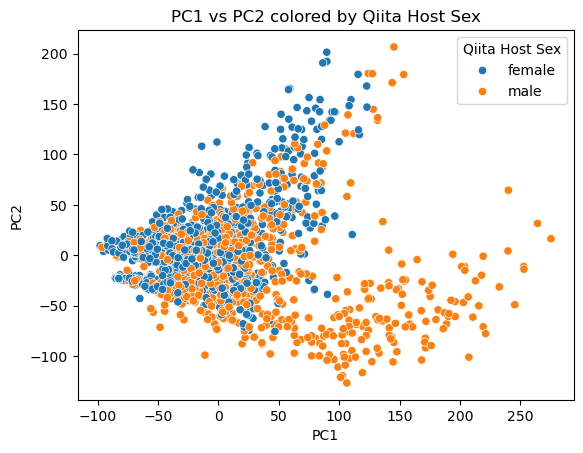

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use seaborn to make the scatter plot
sns.scatterplot(data=df, x=0, y=1, hue='qiita_host_sex')

# Add titles and labels (optional)
plt.title('PC1 vs PC2 colored by Qiita Host Sex')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show legend and plot
plt.legend(title='Qiita Host Sex')
plt.show()


In [37]:
# Assuming 'df' is your DataFrame and 'sex' is the binary classification target
y = df['qiita_host_sex'].astype('category').cat.codes

X_pca_tensor = torch.tensor(df.drop(columns=['qiita_host_sex']).to_numpy(), dtype=torch.float32)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca_tensor, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converting to PyTorch tensors
train_features = torch.tensor(X_train_scaled, dtype=torch.float32)
test_features = torch.tensor(X_test_scaled, dtype=torch.float32)
train_targets = torch.tensor(y_train.values, dtype=torch.long)  # Use torch.long for classification targets
test_targets = torch.tensor(y_test.values, dtype=torch.long)

# Creating DataLoader instances
train_dataset = TensorDataset(train_features, train_targets)
test_dataset = TensorDataset(test_features, test_targets)

batch_size = 512  # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the classification model (assuming two classes, binary classification)
classification_model = trpca.TransformerClassificationModel(feature_size=n_dimensions, num_classes=len(y.unique()), num_transformer_layers=3, nhead=8, dim_feedforward=1024, dropout=0.2, fast_transformer=True)

/Users/tylermyers/anaconda3/envs/trpca_2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [41]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in classification_model.parameters())
trainable_params = sum(p.numel() for p in classification_model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 1519618
Trainable Parameters: 1519618


In [38]:
from tqdm import tqdm
import torch
import torch.optim as optim

# Assuming classification_model has been initialized correctly elsewhere in your code
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
classification_model.to(device)
classification_model.train()

# Set up loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classification_model.parameters(), lr=1e-3, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0, last_epoch=-1)

epochs = 10000
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

pbar = tqdm(total=epochs, desc="Training Progress")

for epoch in range(epochs):
    train_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = classification_model(batch_features)
        loss = criterion(outputs['class_output'], batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_features.size(0)

    # Average train loss for the epoch
    train_loss_epoch = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss_epoch)
    
    # Validation phase
    classification_model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = classification_model(batch_features)
            loss = criterion(outputs['class_output'], batch_labels)
            valid_loss += loss.item() * batch_features.size(0)
    
    # Average valid loss for the epoch
    valid_loss_epoch = valid_loss / len(test_loader.dataset)
    valid_losses.append(valid_loss_epoch)

    scheduler.step()
    # Update the progress bar
    pbar.update(1)
    pbar.set_postfix({
        'Epoch': epoch + 1,
        'Train Loss': f'{train_loss_epoch:.4f}',
        'Validation Loss': f'{valid_loss_epoch:.4f}'
    })
    
    # Check for best validation loss
    if valid_loss_epoch < best_valid_loss:
        best_valid_loss = valid_loss_epoch
        # Save the model
        torch.save(classification_model.state_dict(), 'best_classification_model.pth')
        # Uncomment below to see the message when model improves
        # print(f'Epoch {epoch+1}: Validation loss improved, model saved.')

# Close the progress bar after all epochs are done
pbar.close()


Training Progress: 100%|██████████| 10000/10000 [12:38<00:00, 13.19it/s, Epoch=1e+4, Train Loss=0.1197, Validation Loss=0.2237]


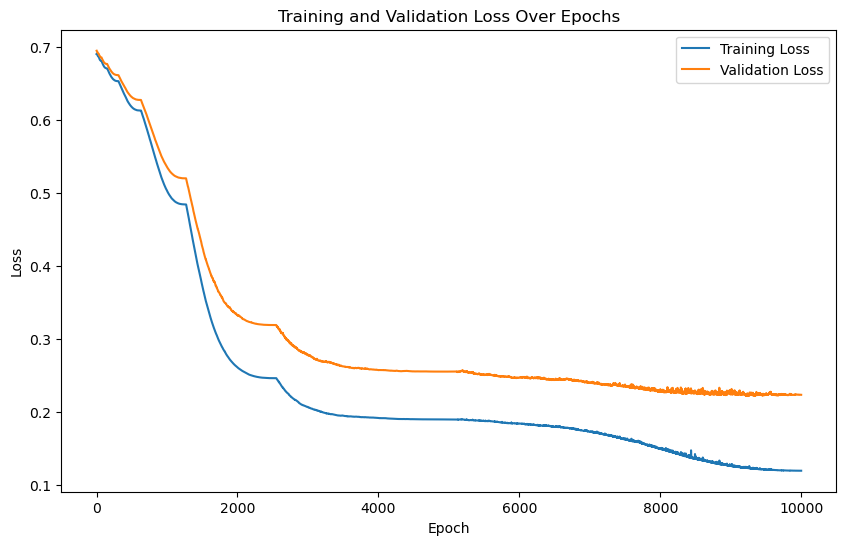

In [39]:
classification_model.load_state_dict(torch.load('best_classification_model.pth'))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

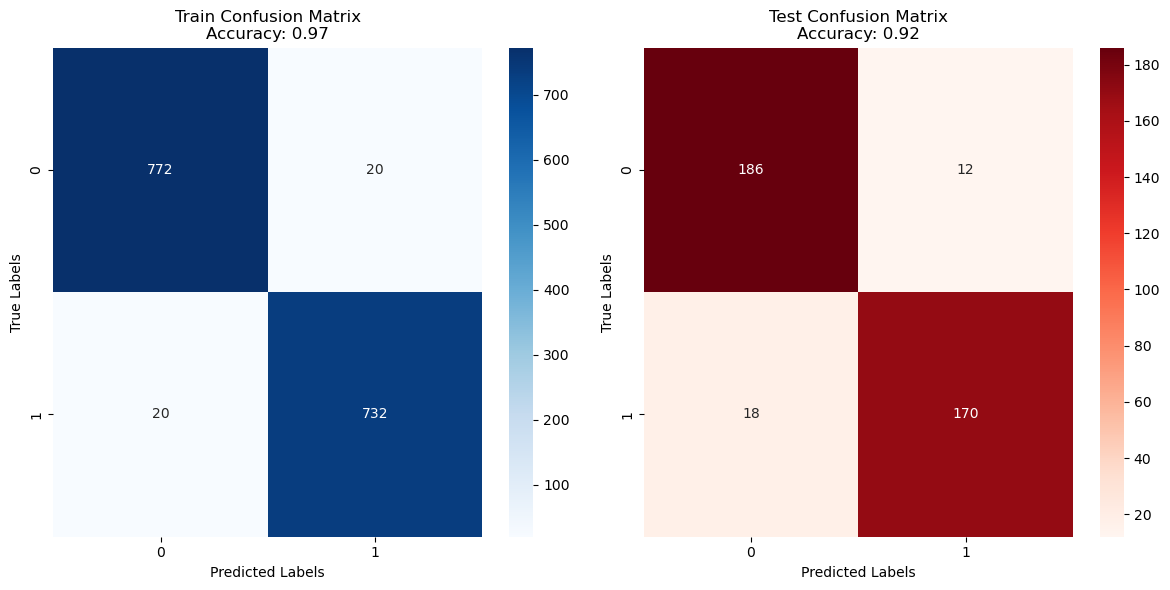

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import numpy as np

# Assuming classification_model has been defined and trained
classification_model.eval()  # Set the model to evaluation mode

# Collect predictions and actual values for the training set
train_preds, train_actuals = [], []
for batch_features, batch_labels in train_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    batch_preds = torch.argmax(classification_model(batch_features)['class_output'].detach(), dim=1)
    train_preds.extend(batch_preds.tolist())
    train_actuals.extend(batch_labels.tolist())

# Collect predictions and actual values for the test set
test_preds, test_actuals = [], []
for batch_features, batch_labels in test_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    batch_preds = torch.argmax(classification_model(batch_features)['class_output'].detach(), dim=1)
    test_preds.extend(batch_preds.tolist())
    test_actuals.extend(batch_labels.tolist())

# Calculate accuracy for training and testing sets
train_accuracy = accuracy_score(train_actuals, train_preds)
test_accuracy = accuracy_score(test_actuals, test_preds)

# Generate confusion matrices for training and testing sets
train_cm = confusion_matrix(train_actuals, train_preds)
test_cm = confusion_matrix(test_actuals, test_preds)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title(f'Train Confusion Matrix\nAccuracy: {train_accuracy:.2f}')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# Test confusion matrix
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Reds', ax=ax[1])
ax[1].set_title(f'Test Confusion Matrix\nAccuracy: {test_accuracy:.2f}')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()
